In [ ]:
# =========================
# 0) UPLOAD + LOAD EXCEL
# =========================
# Objectif: Analyse statistique sur les données brutes (prescriptions répétées)
# Fichier attendu:
# - Sheet "Data brutes": 1 colonne avec les prescriptions ARV (combos)
# - Sheet "Analyse": mapping DCI -> SPECIALITES (ARV) (liste séparée par virgule)

from google.colab import files
uploaded = files.upload()

import pandas as pd
import io

filename = next(iter(uploaded))
xls = pd.ExcelFile(io.BytesIO(uploaded[filename]))
print("Sheets:", xls.sheet_names)

Saving ARV_JL_MBVR (1).xlsx to ARV_JL_MBVR (1).xlsx
Sheets: ['Data brutes', 'Analyse']


In [ ]:
# =========================
# 1) LOAD RAW + MAPPING
# =========================

RAW_SHEET = "Data brutes"
MAP_SHEET = "Analyse"


df_raw = pd.read_excel(io.BytesIO(uploaded[filename]), sheet_name = RAW_SHEET)
df_map = pd.read_excel(io.BytesIO(uploaded[filename]), sheet_name=MAP_SHEET)

print("Raw shape:", df_raw.shape)
print("Raw columns:", df_raw.columns.tolist())

print("Map shape:", df_map.shape)
print("Map columns:", df_map.columns.tolist())

df_raw.head(3)

Raw shape: (19220, 8)
Raw columns: ['ARV présents dans NADIS', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7']
Map shape: (78, 4)
Map columns: ['DCI', 'SPECIALITE contenant la molécule', 'CLASSE ARV', 'Commentaire']


,ARV présents dans NADIS,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,Combivir + Kalétra,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Isentress + Truvada,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Isentress + Kivexa,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# =========================
# 2) FIND THE RAW COLUMN (auto)
# =========================
# On prend la colonne qui contient les prescriptions

RAW_COL = None
for c in df_raw.columns:
    if "ARV" in str(c).upper():
        RAW_COL = c
        break

if RAW_COL is None:
    RAW_COL = df_raw.columns[0]

print("Using RAW_COL:", RAW_COL)
df_raw[[RAW_COL]].head(10)

Using RAW_COL: ARV présents dans NADIS


,ARV présents dans NADIS
0,Combivir + Kalétra
1,Isentress + Truvada
2,Isentress + Kivexa
3,Triumeq
4,Genvoya
5,Biktarvy
6,Lamivudine / Dolutégravir (Dovato)
7,Rilpivirine / Dolutégravir (Juluca)
8,Retrovir + Videx
9,Retrovir + Videx + Invirase


In [ ]:
# =========================
# 3) BUILD ARV -> DCI DICTIONARY (from 'Analyse')
# =========================
# le sheet "Analyse" donne: DCI + "SPECIALITE contenant la molécule" (liste séparée par virgules)
# On inverse: ARV -> set(DCI)

import re
import unicodedata
from collections import defaultdict

SPECIAL_COL = "SPECIALITE contenant la molécule"
DCI_COL = "DCI"

assert SPECIAL_COL in df_map.columns, f"Missing column: {SPECIAL_COL}"
assert DCI_COL in df_map.columns, f"Missing column: {DCI_COL}"

def normalize_text(s: str) -> str:
    """Uppercase + remove accents + trim + normalize spaces."""
    if s is None:
        return ""
    s = str(s).strip()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.upper()
    s = re.sub(r"\s+", " ", s)
    return s.strip()

arv_to_dcis = defaultdict(set)

for _, row in df_map.iterrows():
    dci = normalize_text(row[DCI_COL])
    specs = row[SPECIAL_COL]
    if pd.isna(specs) or specs is None:
        continue

    # split by comma
    for arv in str(specs).split(","):
        arv_norm = normalize_text(arv)
        if arv_norm:
            arv_to_dcis[arv_norm].add(dci)

print("ARV keys in mapping:", len(arv_to_dcis))
# show a few examples
list(sorted(arv_to_dcis.keys()))[:15]

ARV keys in mapping: 68


['ABT 378',
 'AGENERASE',
 'ALUVIA',
 'APLAVIROC',
 'APTIVUS',
 'ATRIPLA',
 'BIKTARVY',
 'CELSENTRI',
 'COMBIVIR',
 'COVIRACIL',
 'CRIVIXAN',
 'DELSTRIGO',
 'DESCOVY',
 'DOVATO',
 'DUTREBIS']

In [ ]:
# =========================
# 4) PARSE RAW PRESCRIPTIONS INTO ARV TOKENS
# =========================
# Raw text looks like: "Epivir + Kaletra + Norvir + ..."
# On découpe par "+" et on nettoie.

def extract_candidates(token: str):
    """
    Retourne plusieurs versions possibles d'un ARV token:
    - token normalisé
    - contenu entre parenthèses (souvent le nom commercial)
    - parties séparées par "/" (optionnel)
    """
    t = normalize_text(token)

    cands = []
    if t:
        cands.append(t)

    # inside parentheses
    m = re.findall(r"\(([^)]+)\)", str(token))
    for inside in m:
        inside_norm = normalize_text(inside)
        if inside_norm:
            cands.append(inside_norm)

    # split by "/" as extra candidates (sometimes brand is mixed)
    if "/" in str(token):
        for part in str(token).split("/"):
            part_norm = normalize_text(part)
            if part_norm:
                cands.append(part_norm)

    # unique preserve order
    seen = set()
    out = []
    for x in cands:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

def split_raw_combo(raw_line: str):
    if pd.isna(raw_line) or raw_line is None:
        return []
    # split by '+'
    parts = re.split(r"\s*\+\s*", str(raw_line))
    parts = [p.strip() for p in parts if p.strip()]
    return parts

df_raw["raw_text"] = df_raw[RAW_COL].astype(str)
df_raw["ARV_tokens"] = df_raw["raw_text"].apply(split_raw_combo)

df_raw[["raw_text","ARV_tokens"]].head(5)

,raw_text,ARV_tokens
0,Combivir + Kalétra,"[Combivir, Kalétra]"
1,Isentress + Truvada,"[Isentress, Truvada]"
2,Isentress + Kivexa,"[Isentress, Kivexa]"
3,Triumeq,[Triumeq]
4,Genvoya,[Genvoya]


In [ ]:
# =========================
# 5) MAP EACH RAW PRESCRIPTION -> DCI REGIMEN
# =========================
# Pour chaque ligne:
# - on map chaque ARV token -> DCIs via arv_to_dcis
# - on combine toutes les DCIs en un set
# - on garde aussi les ARVs non reconnus (unmapped)

def map_tokens_to_dcis(tokens):
    dcis = set()
    unmapped = []

    for tok in tokens:
        found = False
        for cand in extract_candidates(tok):
            if cand in arv_to_dcis:
                dcis |= arv_to_dcis[cand]
                found = True
                break
        if not found:
            unmapped.append(normalize_text(tok))

    dci_list = sorted(dcis)
    return dci_list, unmapped

mapped = df_raw["ARV_tokens"].apply(map_tokens_to_dcis)
df_raw["DCI_list"] = mapped.apply(lambda x: x[0])
df_raw["unmapped_ARV"] = mapped.apply(lambda x: x[1])

df_raw["n_DCI"] = df_raw["DCI_list"].apply(len)
df_raw["DCI_set"] = df_raw["DCI_list"].apply(lambda xs: "|".join(xs))

# mapping success rate
mapped_rows = (df_raw["n_DCI"] > 0).sum()
total_rows = len(df_raw)
print(f"Mapped rows: {mapped_rows}/{total_rows} ({mapped_rows/total_rows*100:.2f}%)")
df_raw[["raw_text","DCI_set","n_DCI","unmapped_ARV"]].head(10)

Mapped rows: 19140/19220 (99.58%)


,raw_text,DCI_set,n_DCI,unmapped_ARV
0,Combivir + Kalétra,LAMVUDINE +ZIDOVUDINE|LOPINAVIR|LOPINAVIR + RI...,4,[]
1,Isentress + Truvada,EMTRICITABINE + TENOFOVIR DISOPROXIL FUMARATE|...,4,[]
2,Isentress + Kivexa,ABACAVIR|ABACAVIR + LAMIVUDINE|LAMIVUDINE=3TC=...,4,[]
3,Triumeq,ABACAVIR|ABACAVIR + LAMIVUDINE + DOLUTEGRAVIR|...,3,[]
4,Genvoya,COBICISTAT=COBI= GS 9350|ELVITEGRAVIR|ELVITEGR...,5,[]
5,Biktarvy,BICTEGRAVIR + EMTRICITABINE + TENOFOVIR ALAFEN...,4,[]
6,Lamivudine / Dolutégravir (Dovato),DOLUTEGRAVIR + LAMIVUDINE|DOLUTEGRAVIR=DTG=GSK...,3,[]
7,Rilpivirine / Dolutégravir (Juluca),DOLUTEGRAVIR + RILPIVIRINE|DOLUTEGRAVIR=DTG=GS...,3,[]
8,Retrovir + Videx,DIDANOSINE|ZIDOVUDINE,2,[]
9,Retrovir + Videx + Invirase,DIDANOSINE|SAQUINAVIR|ZIDOVUDINE,3,[]


In [ ]:
# =========================
# 6) RAW STATISTICS (frequency / usage)
# =========================
# Ici, on garde les répétitions (c'est le but du raw).
# On fait les stats uniquement sur les lignes mappées (n_DCI > 0)

df_m = df_raw[df_raw["n_DCI"] > 0].copy()
df_u = df_raw[df_raw["n_DCI"] == 0].copy()

print("Mapped:", df_m.shape, "Unmapped:", df_u.shape)

# A) Most common raw ARV combos (as written)
top_arv_combos = df_m["raw_text"].value_counts().reset_index()
top_arv_combos.columns = ["ARV_combo_raw", "prescription_count"]

# B) Most common molecular regimens (DCI_set)
top_regimens = df_m["DCI_set"].value_counts().reset_index()
top_regimens.columns = ["DCI_set", "prescription_count"]

# C) Single vs multi (usage)
pct_single = (df_m["n_DCI"] == 1).mean() * 100
pct_multi  = (df_m["n_DCI"] > 1).mean() * 100

single_multi = pd.DataFrame({
    "type": ["single-DCI", "multi-DCI"],
    "percent_of_prescriptions": [pct_single, pct_multi]
})

# D) Coverage top 5 / top 10 regimens (usage)
reg_freq = df_m["DCI_set"].value_counts(normalize=True)
top5_cov = reg_freq.head(5).sum() * 100
top10_cov = reg_freq.head(10).sum() * 100
coverage = pd.DataFrame({
    "metric": ["Top 5 regimens coverage (%)", "Top 10 regimens coverage (%)"],
    "value": [top5_cov, top10_cov]
})

# E) Most common DCI molecules (usage)
from collections import Counter
dci_counter = Counter()
for row in df_m["DCI_list"]:
    for d in row:
        dci_counter[d] += 1

dci_usage = pd.DataFrame(dci_counter.items(), columns=["DCI", "prescription_count"])
dci_usage["%_of_prescriptions"] = 100 * dci_usage["prescription_count"] / len(df_m)
dci_usage = dci_usage.sort_values("prescription_count", ascending=False)

# F) Regimen size distribution (usage)
regimen_size = df_m["n_DCI"].value_counts().sort_index().reset_index()
regimen_size.columns = ["n_DCI", "prescription_count"]

top_arv_combos.head(10), top_regimens.head(10), dci_usage.head(10)

Mapped: (19140, 14) Unmapped: (80, 14)


(                                       ARV_combo_raw  prescription_count
 0  Norvir + Prezista + Maraviroc + TMC 125 (Etrav...                   1
 1                                 Combivir + Kalétra                   1
 2                                Isentress + Truvada                   1
 3                                 Isentress + Kivexa                   1
 4  Epivir + Kalétra + Norvir + Retrovir + Videx +...                   1
 5  Darunavir (Prezista) + Dovato + Pifeltro (Dora...                   1
 6            Intelence + Kalétra + Norvir + Prezista                   1
 7                 Epivir + Fuzeon + Viramune + Zerit                   1
 8                     Dovato + Rukobia (Fostemsavir)                   1
 9  Dovato + Ibalizumab (Trogarzo) + Rukobia (Fost...                   1,
                                              DCI_set  prescription_count
 0                       LAMIVUDINE=3TC=3TD|STAVUDINE                 115
 1                      LAMIVUDINE=3T

In [ ]:
# =========================
# 7) PAIRS / TRIPLETS (usage)
# =========================
# Fréquence des co-occurrences par prescription

import itertools

pair_counter = Counter()
triplet_counter = Counter()

for row in df_m["DCI_list"]:
    for pair in itertools.combinations(row, 2):
        pair_counter[pair] += 1
    for tri in itertools.combinations(row, 3):
        triplet_counter[tri] += 1

top_pairs = pd.DataFrame(pair_counter.most_common(50), columns=["pair", "prescription_count"])
top_triplets = pd.DataFrame(triplet_counter.most_common(50), columns=["triplet", "prescription_count"])

top_pairs.head(10), top_triplets.head(10)

(                                                pair  prescription_count
 0                    (LAMIVUDINE=3TC=3TD, RITONAVIR)                4674
 1     (RITONAVIR, TENOFOVIR DISOPROXIL FUMARATE=TDF)                4001
 2                              (ABACAVIR, RITONAVIR)                3727
 3                             (LOPINAVIR, RITONAVIR)                3534
 4                 (LOPINAVIR, LOPINAVIR + RITONAVIR)                3533
 5                 (LOPINAVIR + RITONAVIR, RITONAVIR)                3533
 6                     (ABACAVIR, LAMIVUDINE=3TC=3TD)                3476
 7                            (DIDANOSINE, RITONAVIR)                2724
 8  (EMTRICITABINE=FTC=F=EMIVIRINE, TENOFOVIR DISO...                2254
 9  (LAMIVUDINE=3TC=3TD, TENOFOVIR DISOPROXIL FUMA...                2034,
                                              triplet  prescription_count
 0      (LOPINAVIR, LOPINAVIR + RITONAVIR, RITONAVIR)                3533
 1          (ABACAVIR, LAMIVUDINE=3TC

In [ ]:
# =========================
# 8) SUMMARY TABLE + EXPORT EXCEL
# =========================

summary = pd.DataFrame({
    "metric": [
        "n_raw_prescriptions_total",
        "n_raw_prescriptions_mapped",
        "n_raw_prescriptions_unmapped",
        "unique_ARV_combos_raw",
        "unique_regimens_raw (DCI_set)",
        "% single-DCI prescriptions",
        "% multi-DCI prescriptions",
        "Top 5 regimens coverage (%)",
        "Top 10 regimens coverage (%)",
    ],
    "value": [
        len(df_raw),
        len(df_m),
        len(df_u),
        df_m["raw_text"].nunique(),
        df_m["DCI_set"].nunique(),
        pct_single,
        pct_multi,
        top5_cov,
        top10_cov
    ]
})

out_path = "raw_data_results.xlsx"
with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    summary.to_excel(writer, sheet_name="Summary", index=False)
    top_arv_combos.head(200).to_excel(writer, sheet_name="Top_ARV_combos", index=False)
    top_regimens.head(200).to_excel(writer, sheet_name="Top_Regimens", index=False)
    dci_usage.to_excel(writer, sheet_name="DCI_Usage", index=False)
    regimen_size.to_excel(writer, sheet_name="Regimen_Size", index=False)
    coverage.to_excel(writer, sheet_name="Coverage", index=False)
    single_multi.to_excel(writer, sheet_name="Single_vs_Multi", index=False)
    top_pairs.to_excel(writer, sheet_name="Top_Pairs", index=False)
    top_triplets.to_excel(writer, sheet_name="Top_Triplets", index=False)

    # Unmapped lines to debug
    df_u[[RAW_COL, "raw_text", "unmapped_ARV"]].head(500).to_excel(writer, sheet_name="Unmapped_debug", index=False)

print("Saved:", out_path)

from google.colab import files
files.download(out_path)

Saved: raw_data_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

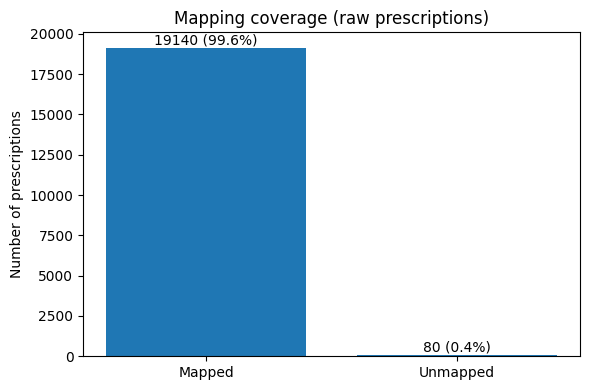

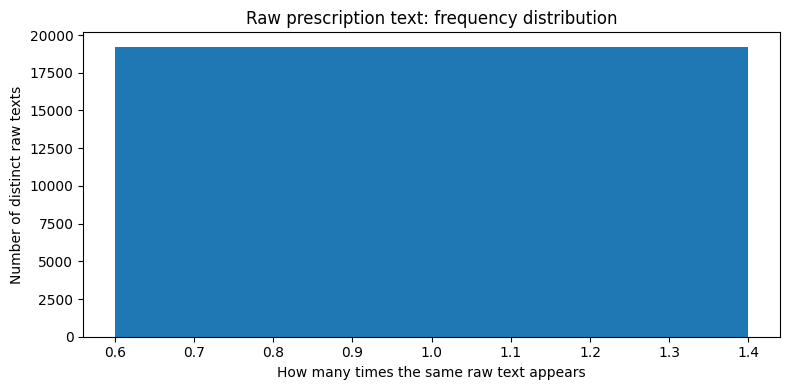

,Example raw prescription,Count
0,Norvir + Prezista + Maraviroc + TMC 125 (Etrav...,1
1,Combivir + Kalétra,1
2,Isentress + Truvada,1
3,Isentress + Kivexa,1
4,Epivir + Kalétra + Norvir + Retrovir + Videx +...,1
5,Darunavir (Prezista) + Dovato + Pifeltro (Dora...,1
6,Intelence + Kalétra + Norvir + Prezista,1
7,Epivir + Fuzeon + Viramune + Zerit,1
8,Dovato + Rukobia (Fostemsavir),1
9,Dovato + Ibalizumab (Trogarzo) + Rukobia (Fost...,1


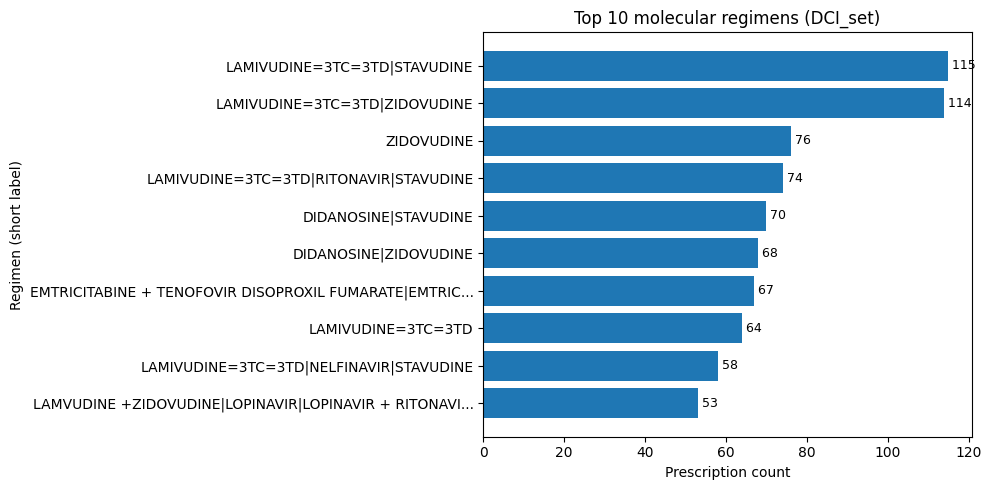

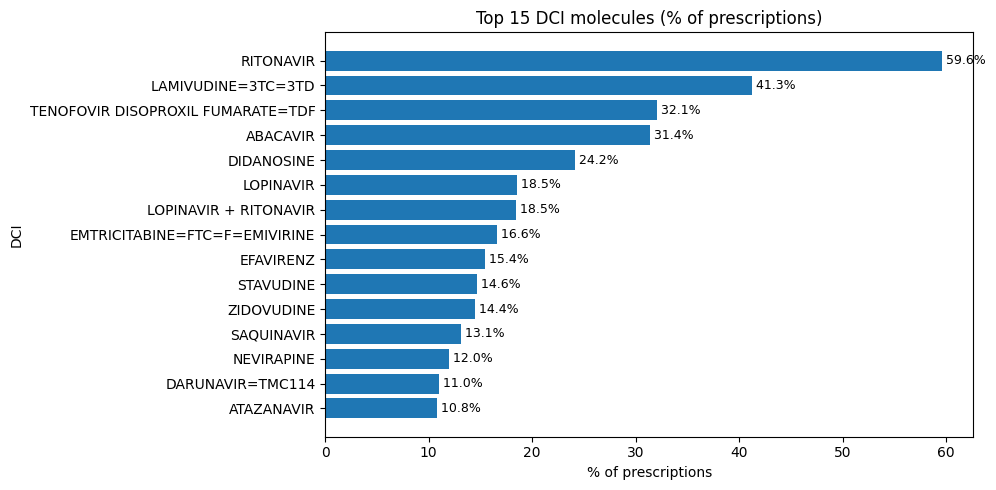

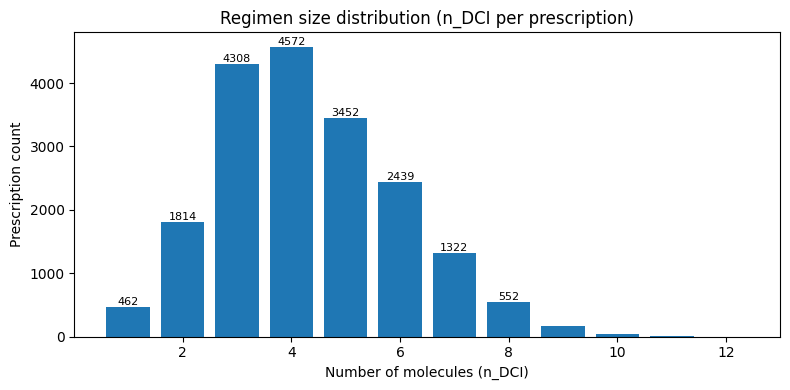

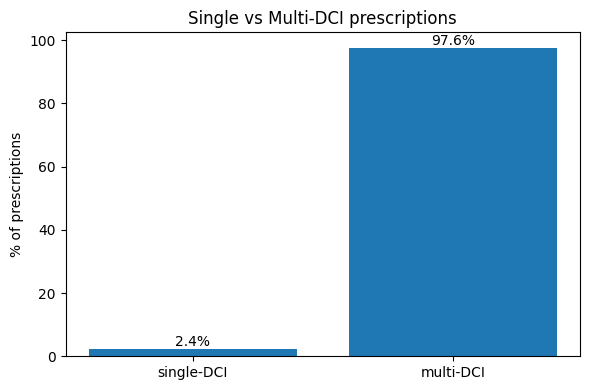

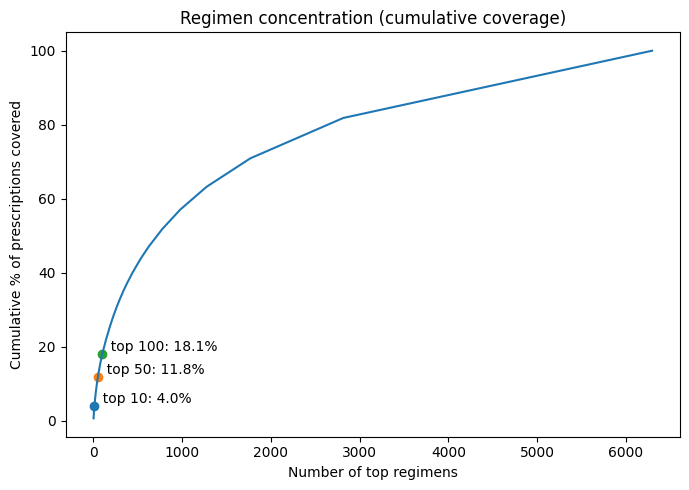

In [ ]:
# =========================
# 9) FIGURES (CLEAN / READABLE)
# =========================
import matplotlib.pyplot as plt
import numpy as np

# ---------- Helpers ----------
def shorten(text, max_len=35):
    s = str(text)
    return s if len(s) <= max_len else s[:max_len-3] + "..."

def add_bar_labels(ax, values, is_percent=False):
    for i, v in enumerate(values):
        label = f"{v:.1f}%" if is_percent else f"{int(v)}"
        ax.text(i, v, label, ha="center", va="bottom", fontsize=9)

def plot_top_hbar(df, label_col, value_col, n=10, title="", xlabel="", ylabel="", percent=False, max_label=45):
    d = df.head(n).copy()
    d[label_col] = d[label_col].apply(lambda x: shorten(x, max_label))
    d = d.iloc[::-1]  # reverse for top on top in horizontal bar
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.barh(d[label_col], d[value_col])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add numbers at end of bars
    for y, v in enumerate(d[value_col].values):
        lab = f"{v:.1f}%" if percent else f"{int(v)}"
        ax.text(v, y, " " + lab, va="center", fontsize=9)
    plt.tight_layout()
    plt.show()
    print("\n")


import os

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)


# =========================
# 9.1 Mapping coverage (bar + %)
# =========================
mapped = len(df_m)
unmapped = len(df_u)
total = mapped + unmapped
mapped_pct = mapped / total * 100
unmapped_pct = unmapped / total * 100

fig, ax = plt.subplots(figsize=(6,4))
vals = [mapped, unmapped]
ax.bar(["Mapped", "Unmapped"], vals)
ax.set_title("Mapping coverage (raw prescriptions)")
ax.set_ylabel("Number of prescriptions")

# add count + percent
ax.text(0, mapped, f"{mapped} ({mapped_pct:.1f}%)", ha="center", va="bottom")
ax.text(1, unmapped, f"{unmapped} ({unmapped_pct:.1f}%)", ha="center", va="bottom")

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/01_mapping_coverage.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n")

# =========================
# 9.2 IMPORTANT FIX: Raw ARV strings are too fragmented
# Instead of "Top 10 raw combos", show "Distribution of frequencies"
# =========================
raw_counts = df_raw[RAW_COL].astype(str).str.strip().value_counts()
freq_dist = raw_counts.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(freq_dist.index.astype(int), freq_dist.values)
ax.set_title("Raw prescription text: frequency distribution")
ax.set_xlabel("How many times the same raw text appears")
ax.set_ylabel("Number of distinct raw texts")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/02_raw_frequency_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n")

# Optional: show ONLY examples (not top frequency) because it's messy
examples = raw_counts.head(10).reset_index()
examples.columns = ["Example raw prescription", "Count"]
examples["Example raw prescription"] = examples["Example raw prescription"].apply(lambda x: shorten(x, 80))
display(examples)

# =========================
# 9.3 Top 10 molecular regimens (DCI_set) (horizontal bar, shortened)
# =========================
# make a shorter label version for readability
top_regimens_plot = top_regimens.copy()
top_regimens_plot["regimen_short"] = top_regimens_plot["DCI_set"].apply(lambda x: shorten(x, 55))

plot_top_hbar(
    top_regimens_plot,
    label_col="regimen_short",
    value_col="prescription_count",
    n=10,
    title="Top 10 molecular regimens (DCI_set)",
    xlabel="Prescription count",
    ylabel="Regimen (short label)",
    percent=False,
    max_label=55
)

# =========================
# 9.4 Top 15 DCI molecules (% of prescriptions) (horizontal bar)
# =========================
plot_top_hbar(
    dci_usage,
    label_col="DCI",
    value_col="%_of_prescriptions",
    n=15,
    title="Top 15 DCI molecules (% of prescriptions)",
    xlabel="% of prescriptions",
    ylabel="DCI",
    percent=True,
    max_label=35
)

# =========================
# 9.5 Regimen size distribution (n_DCI) with labels
# =========================
fig, ax = plt.subplots(figsize=(8,4))
x = regimen_size["n_DCI"].astype(int).values
y = regimen_size["prescription_count"].values
ax.bar(x, y)
ax.set_title("Regimen size distribution (n_DCI per prescription)")
ax.set_xlabel("Number of molecules (n_DCI)")
ax.set_ylabel("Prescription count")

# label only if bar is not too small
for xi, yi in zip(x, y):
    if yi > max(y) * 0.05:
        ax.text(xi, yi, str(int(yi)), ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()
print("\n")

# =========================
# 9.6 Single vs Multi (bar instead of pie for clarity)
# =========================
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(single_multi["type"], single_multi["percent_of_prescriptions"])
ax.set_title("Single vs Multi-DCI prescriptions")
ax.set_ylabel("% of prescriptions")
for i, v in enumerate(single_multi["percent_of_prescriptions"]):
    ax.text(i, v, f"{v:.1f}%", ha="center", va="bottom")
plt.tight_layout()
plt.show()
print("\n")

# =========================
# 9.7 Concentration curve (clean) + markers for top 10, top 50, top 100
# =========================
reg_counts = df_m["DCI_set"].value_counts()
cum_pct = reg_counts.cumsum() / reg_counts.sum() * 100

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(1, len(cum_pct)+1), cum_pct.values)
ax.set_title("Regimen concentration (cumulative coverage)")
ax.set_xlabel("Number of top regimens")
ax.set_ylabel("Cumulative % of prescriptions covered")

for k in [10, 50, 100]:
    if k <= len(cum_pct):
        ax.scatter(k, cum_pct.iloc[k-1])
        ax.text(k, cum_pct.iloc[k-1], f"  top {k}: {cum_pct.iloc[k-1]:.1f}%", va="bottom")

plt.tight_layout()
plt.show()
print("\n")
